# Options on realized variance by transform methods

*Drimus, G. G. (2012). Options on realized variance by transform methods: a non-affine stochastic volatility model. Quantitative Finance, 12(11), 1679-1694.*

**Name:** Shen Mengjing, Wang Yuteng

## 1 Introduction
previous works review

### 1.1 Main Purpose

To price and hedge the options on realized variance 
$$C(K) = E(\frac{1}{T} \int_{0}^{T}v_t dt-K)_+ \tag{1}$$ 
in the Heston model and 3/2 model. $K$ is the variance strike.

### 1.2 Main improvement
- Improve the result by using control variate, eliminating the decaying terms in Laplace transform formula of $C(K)$. 
- Apply a numerical Laplace inversion algorithm GQ_FFT proposed by Iseger(2006).

### 1.3 Model choice
Comparing to Heston model, 3/2 model is more suitable to simulate the variance options under this scheme.

In [7]:
import numpy as np

from laplace_variance import wang
from laplace_variance import shen

## 2 Model descriptions and properities

### 2.1 Heston model
Heston model assumes the following dynamics under pricing measure $\mathbb{Q}$:

\begin{align}
\frac{dS_t}{S_t} &= (r - \delta) dt + \sqrt{v_t} dB_t \tag{2} \\ 
dv_t &= k(\theta(t) - v_t)dt + \epsilon \sqrt{v_t} dW_t \tag{3}
\end{align}

where $r$ is the risk-free rate in the economy, $\delta$ is the dividend yield, and $B_t$ and $W_t$ are one-dimensional standard Brownian motions with correlation $\rho$. Theparameters of the instantaneous variance diffusion have the usual meaning: $k$ is the speed of mean reversion, $\theta$ is the mean reversion level and $epsilon$ is the volatility of volatility.

In Figure 1, we fit Heston model to market prices of S&P 500 European options using FFT algorithm (Carr and Madan, 1999). The fit is done to two maturities: 3 months (T = 0.25) and 6 months (T = 0.5) on July 31, 2009.

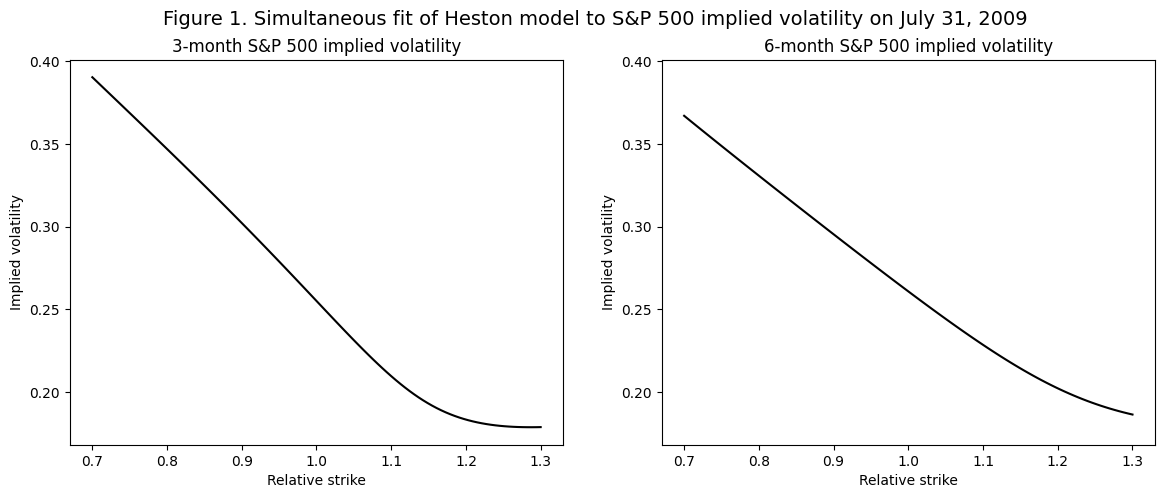

In [8]:
# Heston model
strike = np.linspace(0.7, 1.3, 100)
# Parameters of Heston model of S&P 500 on July 31, 2009
sigma, vov, mr, rho, theta, texp, texp2, spot = 0.2556 ** 2, 0.9288, 3.8, -0.7829, 0.3095 ** 2, 0.25, 0.5, 1

shen.plot_figure1(sigma, vov, mr, rho, theta, strike, spot, texp, texp2)

### 2.2 3/2 model
3/2 model assumes the following dynamics under pricing measure $\mathbb{Q}$:

\begin{align}
\frac{dS_t}{S_t} &= (r - \delta) dt + \sqrt{v_t} dB_t \tag{4} \\
dv_t &= k v_t (\theta(t) - v_t)dt + \epsilon v_t^{3/2} dW_t \tag{5}
\end{align}

In figure 2, we fit 3/2 model to market prices of S&P 500 European options. The fit is done to two maturities: 3 months (T = 0.25) and 6 months (T = 0.5) on July 31, 2009.

**Comparison between the two models**: As relative strike grows, the decline rate of implied volatility in Heston model decreased, while in 3/2 model the decline rate of implied volatility keeps the same.

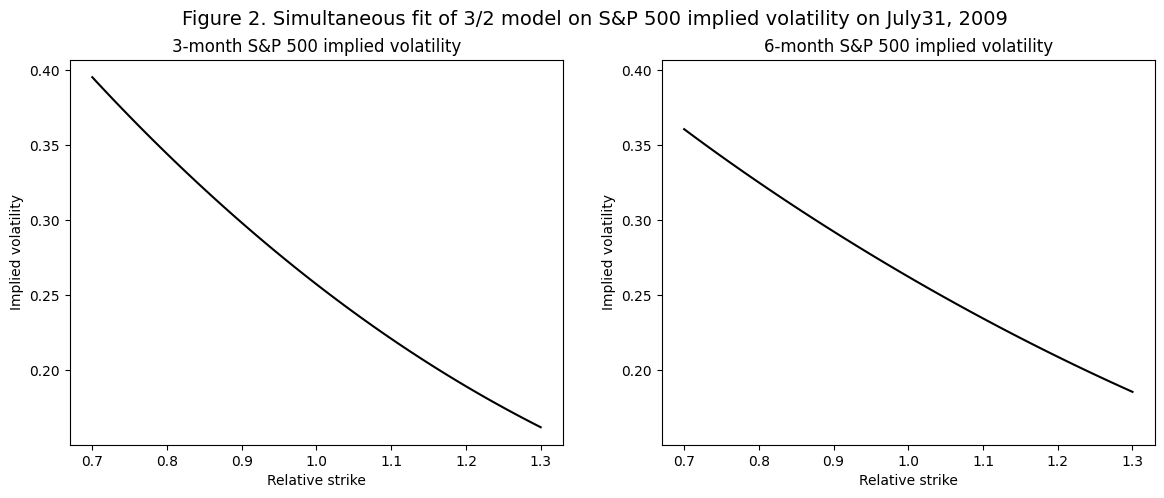

In [9]:
# 3/2 model
strike = np.linspace(0.7, 1.3, 100) * 100
sigma, vov, mr, rho, theta, texp, texp2, spot = 0.2450 ** 2, 8.56, 22.84, -0.99, 0.4669 ** 2, 0.25, 0.5, 100

shen.plot_figure2(sigma, vov, mr, rho, theta, strike, spot, texp, texp2)

### 2.3 Instantaneous volatility paths

Figure 3 shows the instantaneous volatility paths of Heston model and 3/2 model, given expiry time $T=1$ and all the model parameters based on the S&P 500 European options on July 31, 2009.
It illustrates two qualitative differences between the evolution of instantaneous variance in the Heston model versus the 3/2 model: 
- the Heston volatility paths spend much more time around the zero boundary and 
- the 3/2 model allows for the occurrence of extreme paths with short-term spikes in instantaneous volatility. 

From a trading and risk management perspective, both of these observations **favor the 3/2 model**. It is hard to justify a vanishing variance process and the non-existence of high (or extreme) volatility scenarios. In the 3/2 model, the process will revert faster towards the mean after short-term spikes in the instantaneous variance.

In [10]:
# parameters for Heston model
v0_H, k_H, θ_H, ε_H, ρ_H = 0.2556**2, 3.8, 0.3095**2, 0.9288, -0.7829
# parameters for 3/2 model
v0_32, k_32, θ_32, ε_32, ρ_32 = 0.2450**2, 22.84, 0.4669**2, 8.56, -0.99

v_heston = wang.variance_heston(v0_H, k_H, θ_H, ε_H, ρ_H)
v_32 = wang.variance_32(v0_32, k_32, θ_32, ε_32, ρ_32)

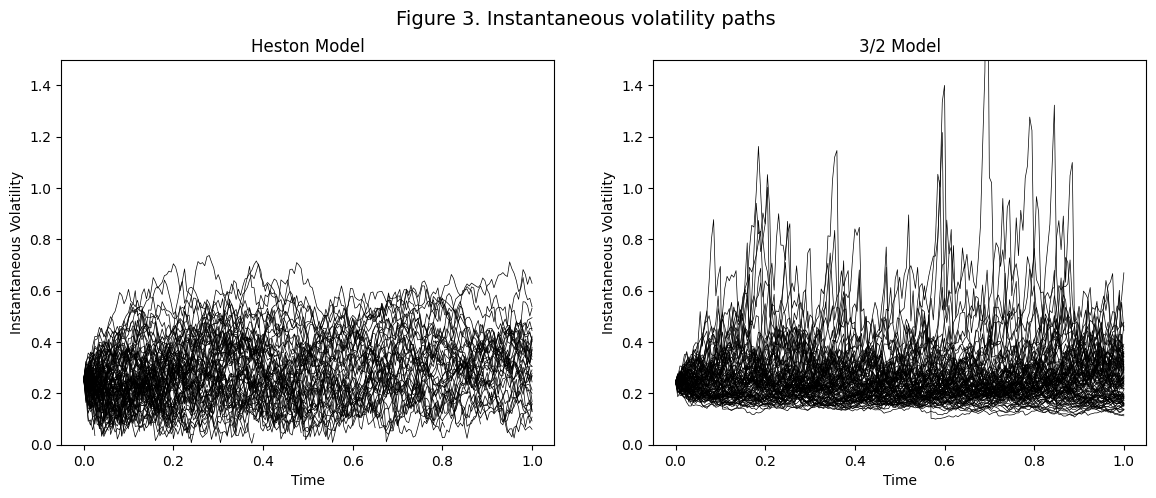

In [11]:
n_observe = int(1e2)
dt = 5e-3
texp = 1

path_heston, C0_heston = wang.C0_simulation_heston(v_heston, n_observe, dt, texp)
path_32, C0_32 = wang.C0_simulation_32(v_32, n_observe, dt, texp)
wang.plot_figure3(path_heston, path_32, dt)

In [71]:
n = 10000
path, _ = wang.C0_simulation_heston(v_heston, n, dt, texp)
np.isnan(path[:, -1]).sum() / n 

0.4368

In [76]:
path[:, -1][~ np.isnan(path[:, -1])]

array([0.0068732 , 0.08996859, 0.05245273, ..., 0.00511836, 0.15863917,
       0.17914568])

## 2.4 Implied volatility smiles in the neighborhood of X = T = 0

We make use of the implied volatility expansion derived by Medvedev and Scailett (2007) for short times to expira-options. Letting $X = log(K/S_0 e^{(r-\delta)T})$ denote the log-forward-moneyness corresponding to a European option with strike $k$ and maturity $T$.

Medvedev and Scaillet (2007) obtain the following expansions for implied volatility $I(X, T)$ in the neighborhood of $X = T = 0$.

For the Heston model,

\begin{align}
I(X, T)= \sqrt{v_{0}}+\frac{\rho \epsilon X}{4 \sqrt{v_{0}}}+\left(1-\frac{5 \rho^{2}}{2}\right) \frac{\epsilon^{2} X^{2}}{24 v_{0}^{3 / 2}} 
+\left(\frac{k\left(\theta-v_{0}\right)}{4 \sqrt{v_{0}}}+\frac{\rho \epsilon \sqrt{v_{0}}}{8}+\frac{\rho^{2} \epsilon^{2}}{96 \sqrt{v_{0}}}-\frac{\epsilon^{2}}{24 \sqrt{v_{0}}}\right) T+\cdots \tag{6}
\end{align}

For the 3/2 model, 
\begin{align}
I(X, T)= \sqrt{v_{0}}+\frac{\rho \epsilon \sqrt{v_{0}} X}{4}+\left(1-\frac{\rho^{2}}{2}\right) \frac{\epsilon^{2} \sqrt{v_{0}} X^{2}}{24} 
+\left(\frac{k\left(\theta-v_{0}\right)}{4}+\frac{\rho \epsilon v_{0}}{8}-\frac{7 \rho^{2} \epsilon^{2} v_{0}}{96}-\frac{\epsilon^{2} v_{0}}{24}\right) \sqrt{v_{0}} T+\cdots \tag{7}
\end{align}

Figure 4 shows the comparison between true model implied volatility and Medvedev and Scaillet approximation around $X = 0$ and a small 
$T = 1$-month.

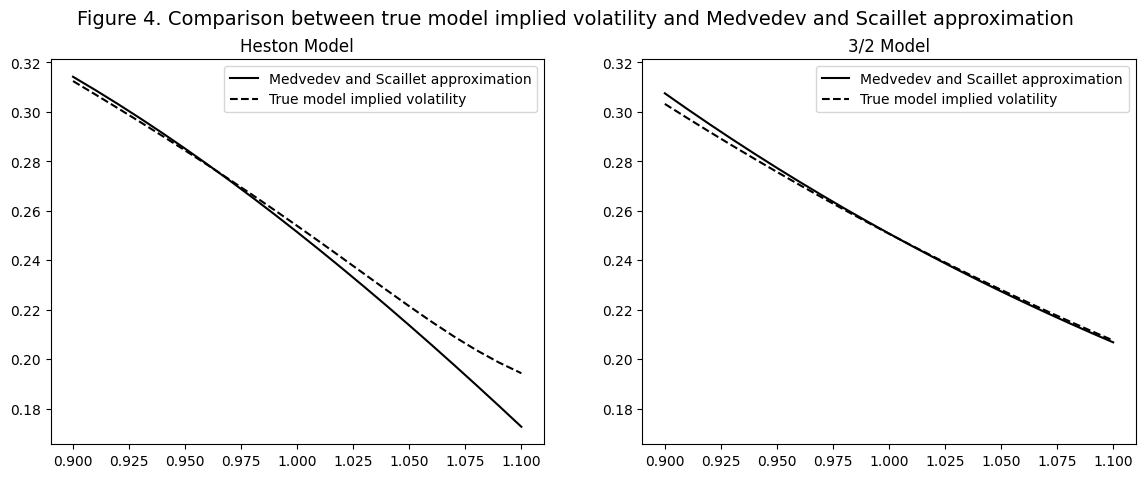

In [13]:
strike = np.arange(0.9, 1.1, 0.01)
spot = 1.0
texp = 1/12

wang.plot_figure4(v_heston, v_32, strike, spot, texp)

## 3 Transform pricing of options on realized variance

### Step 0. Comparison results

Before we apply laplace transform to realized variance, we first conduct simple MC simulation.

#### Step 0.1. MC simulation

#### Step 0.2. Cond MC simulation

### Step 1. Derive the Laplace Tranform of the annualized realized variance over $[0, T]$

The annualized realized variance is $C(0) = \frac{1}{T} \int_{0}^{T} v_t dt$, and its laplace transform is 

$$\mathcal{L}(\lambda) = E(e^{-\lambda C(0)}) = E(e^{-\lambda \frac{1}{T} \int_{0}^{T} v_t dt}) \tag{8}$$

For Heston model, we have

$$E(e^{-\lambda \int_{0}^{T} v_t dt} | v_0) = exp(a(0, T)-b(0, T)v_0) \tag{9}$$

where

\begin{align*}
a(0, T) & =-\int_{0}^{T} k \theta(s) b(s, T) \mathrm{d} s, \\
b(t, T) & =\frac{\left(i u+u^{2}+2 \lambda\right)\left(\mathrm{e}^{\gamma(T-t)}-1\right)}{(\gamma+k-i \epsilon \rho u)\left(\mathrm{e}^{\gamma(T-t)}-1\right)+2 \gamma}, \\
\gamma & =\sqrt{k^2 + 2 \lambda \epsilon^2}.
\end{align*}

For 3/2 model, we have
$$E(e^{-\lambda \int_{0}^{T} v_t dt} | v_0) = \frac{\Gamma(\gamma - \alpha)}{\Gamma(\gamma)}(\frac{2}{\epsilon^2 y} M(\alpha, \gamma, \frac{-2}{\epsilon^2 y})) \tag{10}$$

where

\begin{align*}
y &= v_0 \int_{0}^{T} e^{\int_{0}^{u} k\theta(s)ds}du, \\
\alpha &= -(\frac{1}{2}+\frac{k}{\epsilon^2}) + \sqrt((\frac{1}{2}+\frac{k}{\epsilon^2})^2 + 2\frac{\lambda}{\epsilon^2}), \\
\gamma &= 2(\alpha+1+\frac{k}{\epsilon^2}),
\end{align*}
and $M(\cdot)$ is the confluent hypergeometric function.

For numerical calculation, we have the function `L_C0_heston` and `L_C0_32` to help with Laplace transform.

In [14]:
λ = complex(1, 1)
wang.L_C0_heston(v_heston, λ, texp), wang.L_C0_32(v_32, λ, texp)

((1.7273307545787993+0.7414963426235274j),
 (0.6929478853796637-0.17340068749576723j))

In [15]:
wang.L_C0_heston(v_heston, 2 ** 5, texp)

21.919472304740783

### Step 2. Express the Laplace transform of variance call function with the Laplace transform of annulized realized variance

It is proved in the paper that, the undiscounted variance call function C(K) as mentioned in (1), can be expressed as

$$L(\lambda) = \int_{0}^{\infty} e^{-\lambda K} C(K)dK = \frac{\mathcal{L}(\lambda)-1}{\lambda^2} + \frac{C(0)}{\lambda} \tag{11}$$

#### Step 2.1 A fast result

From obtaining $L(\lambda)$, it is already possible for us to express $C(K)$ numerically, using $C(0)$ from $\textit{Step 3}$

### Step 3. Apply control variate

The two polynomially decaying terms appear in expression (11) $\frac{-1}{\lambda^2} + \frac{C(0)}{\lambda}$ decaying slowly as $|\lambda| \rightarrow \infty$, affecting the accuracy of numerical inversion algorithms. Choose control variate function $\tilde{C}(\cdot)$ to eliminate the slowly decaying terms. With the linearity of Laplace transform, we have

$$ L_ {C-\tilde{C}}  ( \lambda ) = L_ {C}( \lambda) - L_ {\tilde{C}}( \lambda)= \frac{\mathcal{L}(\lambda)-\tilde{\mathcal{L}}(\lambda)}{\lambda^2} \tag{12}$$

we choose the Gamma distribution as our proxy distribution. The Laplace transform is known in closed form and the following
expression (13) shows how to compute the control variate function $\tilde{C}(\cdot)$.

$$\tilde{C}(K) = \alpha \beta (1 - F(K;\alpha+1, \beta)) - K (1 - F(K;\alpha, \beta)) \tag{13}$$

where
\begin{align*}
\alpha &= \frac{C(0)}{\beta}, \\
\beta &= C(0)e^{\sigma^2 T-1},
\end{align*}
and $F(\cdot)$ is CDF of Gamma distribution.

In Figure 5, using $\tilde{C}(K)$, we estimate the variance call price and implied volatility. The result will be a little bit different from calculation from original $C(K)$, but they show the similar trend.

d:\Code\Python3.10\lib\site-packages\pyfeng\bsm.py:444: RuntimeWarning: invalid value encountered in log
  log_p_2pi = np.log(p) + MathConsts.M_LN2PI_2  # 0.5*np.log(2*np.pi)


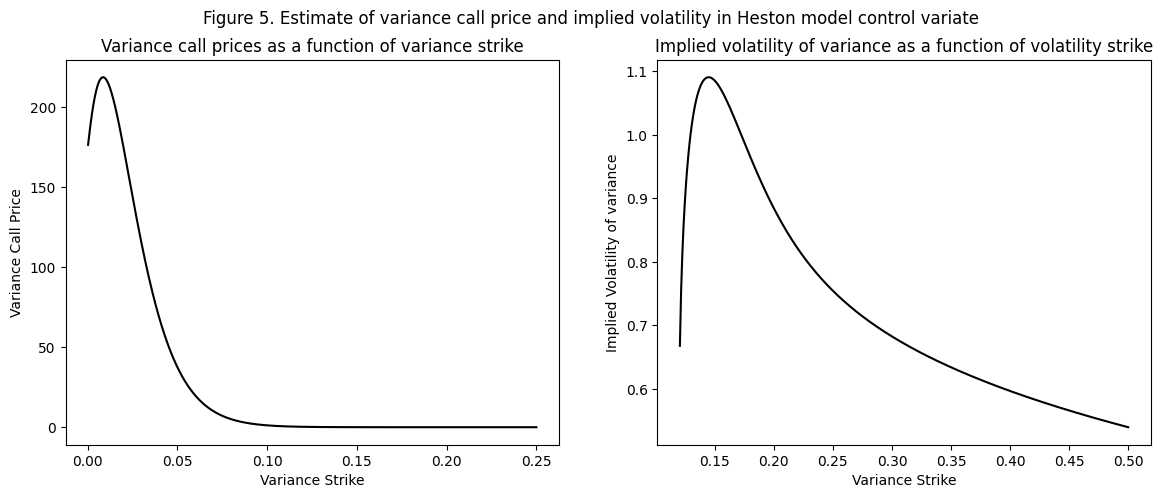

In [16]:
# Refers to parameters given on Page 1688
v0, k, theta, epsilon = 0.0348, 1.15, 0.0348, 0.39
max_strike, texp = 0.25, 0.5

c = shen.cbarheston(texp, k, v0, theta)
shen.plot_figure5(c, v0, max_strike, texp)

In [17]:
c.cbar(np.arange(0.01, 0.25, 0.01))

array([2.17804342e-02, 1.74858105e-02, 1.15107173e-02, 6.80032843e-03,
       3.75435589e-03, 1.97887377e-03, 1.00850849e-03, 5.01002876e-04,
       2.43942357e-04, 1.16872735e-04, 5.52537429e-05, 2.58328875e-05,
       1.19639634e-05, 5.49595772e-06, 2.50691910e-06, 1.13643124e-06,
       5.12346436e-07, 2.29859598e-07, 1.02673896e-07, 4.56818265e-08,
       2.02522843e-08, 8.94934244e-09, 3.94290440e-09, 1.73243053e-09])

### Step 4. Numerical Laplace inversion algorithms

Now we have $\tilde{C}(K)$, $\mathcal{L}(\lambda)$ which is the Laplace transform of annualized realized variance, and the Laplace transform of $\tilde{C}(K)$, denotes $\tilde{\mathcal{L}}(\lambda)$ is able to obtain. We can apply expression (12) to calculate $L_{C-\tilde{C}}(\lambda)$ and a Laplace inversion method is required to convert $L_{C-\tilde{C}}(\lambda)$ to $C(K) - \tilde{C}(K)$.

Drimus applied the Iseger (2006) numerical Laplace inversion algorithms called Gaussian-Quadrature-FFT algorithm. Let $g(\cdot) = C(\cdot) - \tilde{C}(\cdot)$ and $\hat{g}(\cdot)$ be the Laplace transform of $g(\cdot)$. Using Poisson summation formula, $g(\cdot)$ can be expressed as 

$$g(k) = \frac{e^{ak}}{M_2}\cdot \sum_{j=0}^{M_2-1}[e^{2\pi i k\frac{j}{M2}} \sum_{l=1}^{n}\beta_l \cdot \hat{g}(a+i\lambda_l+2\pi i \frac{j}{M2})] \tag{14}$$

where 
\begin{align*}
M &= 2^m, \\
M_2 &= 8M, \\
a &= \frac{44}{M_2}, \\
n &= 16,
\end{align*}
and the exact values of the quadrature weights $\beta_k$ and the quadrature points $\lambda_k$ can be found in Iseger(2006).


In [18]:
wang.direct_Lk(complex(1, 1), C0_heston, 'Heston', v_heston, 0.5)

(3.5876939803966854+15.715215683064262j)

In [29]:
# correct usage of C0
wang.direct_Lk(1, c.c0(), 'Heston', v_heston, 0.5)

23.707295711101334

In [20]:
wang.direct_Lk(complex(1, 1), C0_32, '3/2', v_32, 0.5)

(-0.0469453974620725+0.10602705362612017j)

In [28]:
params = wang.parameters_inv(times = 5)
g_hat = lambda x: wang.direct_Lk(x, c.c0(), 'Heston', v_heston, texp)
wang.inv_algo_ghat(params, g_hat)

[(-3.7193224036838616e+16-30183226686028.336j),
 (3093469288740940-35843468557483.12j),
 (1783864809452455.8-42565172090788.516j),
 (1398508361395102.5-50547392540929.234j),
 (1239256843060285.5-60026513863331.2j),
 (1173465152446933-71283248958503.23j),
 (1158446945800475.5-84650952637016.9j),
 (1176813181098544-100525493535488.53j),
 (1220664279163669.5-119376977289029.53j),
 (1286405083795305.2-141763668158193.3j),
 (1372708014700711.8-168348521343251.34j),
 (1479614060825671.5-199918815639296.22j),
 (1608108295016091.5-237409467742953.44j),
 (1759917135117370.2-281930718699063.9j),
 (1937420239499830-334801012350466.8j),
 (2143627974608957.2-397586039538879.1j),
 (2382200787975695.5-472145104136481.5j),
 (2657498863193170-560686184090232.25j),
 (2974656578637430-665831318109905.5j),
 (3339679682356898-790694254219602.5j),
 (3759565135628669-938972659675389j),
 (4242444947495003.5-1115057622979350.5j),
 (4797756359269579-1324163690761133j),
 (5436441618405905-1572483290353669.8j),
 

## 4 Conclusion

- A fast and robust method for determining price for options on realized variance in any model where the Laplace transform of realized variance is in closed form.

- Comparing to Heston model, 3/2 model is preferred.

- Hedge ratio can also be derived using the Laplace formula and inverse transform.

## References

[1] Carr, P. and Madan, D., Option pricing and the fast Fourier transform. J. Comput. Finance, 1999, 2(4), 61–73.

[2] Cooley, J. W., & Tukey, J. W. (1965). An algorithm for the machine calculation of complex Fourier series. Mathematics of computation, 19(90), 297-301.

[3] Den Iseger, P. (2006). Numerical transform inversion using Gaussian quadrature. probability in the Engineering and Informational Sciences, 20(1), 1-44.

[4] Drimus, G. G. (2012). Options on realized variance by transform methods: a non-affine stochastic volatility model. Quantitative Finance, 12(11), 1679-1694.